## Assignment 3 - Identifying spam

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA


from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras import layers, models

# from google.colab import drive

### Data exploration

Firstly, we inspect how the data look like and check whether there are any null values that should be removed:

In [ ]:
# drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/MyDrive/Assignment_3/data/Spam_SMS.csv')

data = pd.read_csv('data.csv')

display(data.head())
display(data.describe())

num_classes = data['Class'].nunique()

missing_values_count = data.isnull().sum()
missing_values_count


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


,Class,Message
count,5574,5574
unique,2,5159
top,ham,"Sorry, I'll call later"
freq,4827,30


,0
Class,0
Message,0


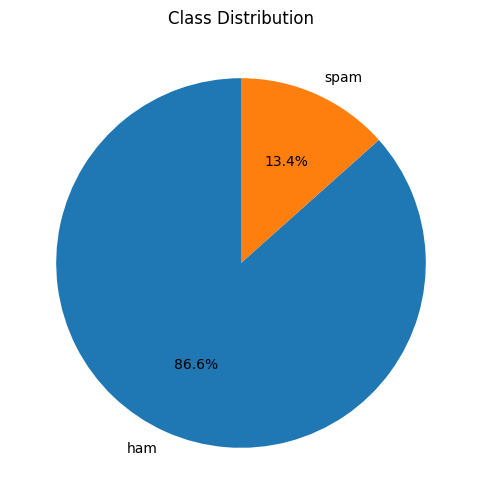

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(data['Class'].value_counts(), labels=data['Class'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')
plt.show()

We can see that there is a lot more ham messages than spam messages. This could prove tough for our model as it could become biased and miss some of the spams.

First we asked what could we do to have a more balanced dataset. We got 2 ideas:
- Remove majority of the ham messages so that we have 50:50 dataset (That would not make any sense as we would lost of lot of valuable data)
- Augment a lot of spam messages (That would have been nice if we could actually do it. We could have used a pre-trained model for that but since it would be a lot out of the scope of this project we decided not to pursue that idea)

Instead, we made some research and found out we could actually use [Focal Loss](https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7) function that deals with the problem of imbalanced datasets. We will talk more about this in the `Implementation` section.

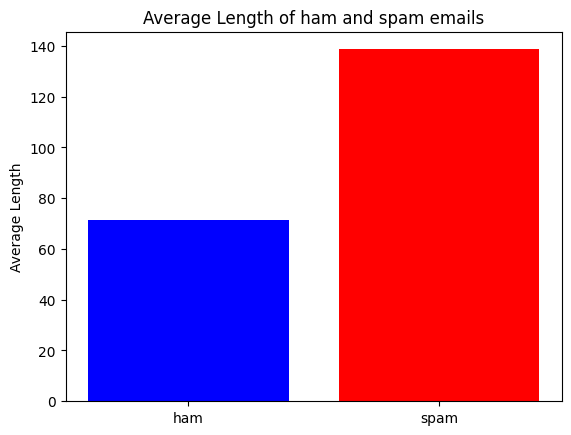

In [ ]:
data['Length'] = data['Message'].apply(len)

avg_length_spam = data[data['Class'] == 'spam']['Length'].mean()
avg_length_ham = data[data['Class'] == 'ham']['Length'].mean()

plt.bar(["ham", "spam"], [avg_length_ham, avg_length_spam], color=['blue', 'red'])
plt.title('Average Length of ham and spam emails')
plt.ylabel('Average Length')
plt.show()

From the plot above, we can see that spam emails are much longer on average. However, we thought that this information is not so important for model, therefore we did not used it for training.

### Data pre-processing

First we check what kind of words are popular to use in each of the message types:

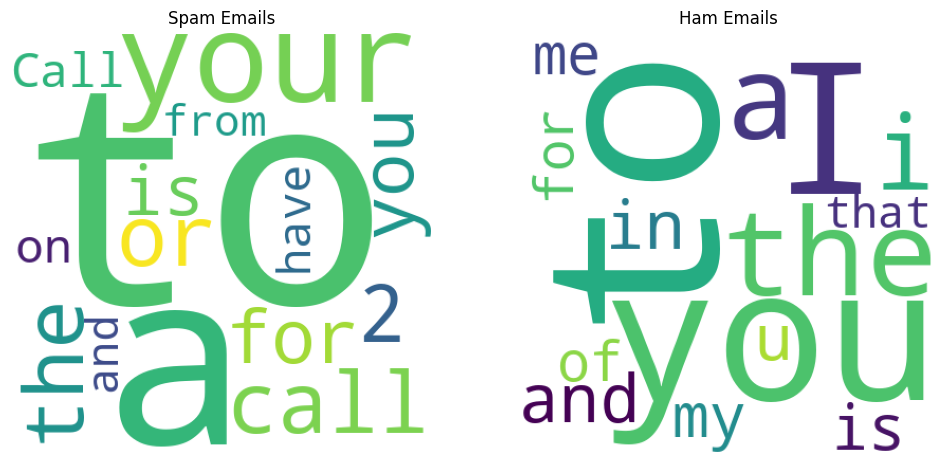

In [ ]:
spam_emails = data[data['Class'] == 'spam']
ham_emails = data[data['Class'] == 'ham']

spam_words = ' '.join(list(spam_emails['Message'])).split()
spam_word_counts = Counter(spam_words)
spam_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(spam_word_counts.most_common((15))))

ham_words = ' '.join(list(ham_emails['Message'])).split()
ham_word_counts = Counter(ham_words)
ham_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(ham_word_counts.most_common((15))))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud)
plt.title('Spam Emails')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud)
plt.title('Ham Emails')
plt.axis('off')

plt.show()



In the plots above, we can see that there are multiple words that are frequent in both, spam and ham emails. This could be very confusing for our model so to make it better we will remove those words from all the messages.

The words we will remove (we basically took the ones that look similarly important in both plots):
- to
- the
- and
- a
- is

In [ ]:
stopwords = ['to', 'the', 'and', 'a', 'is']

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

data['transformed_message'] = data['Message'].apply(remove_stopwords)

After removing the words used in both message types, those are the 15 most common words in each:

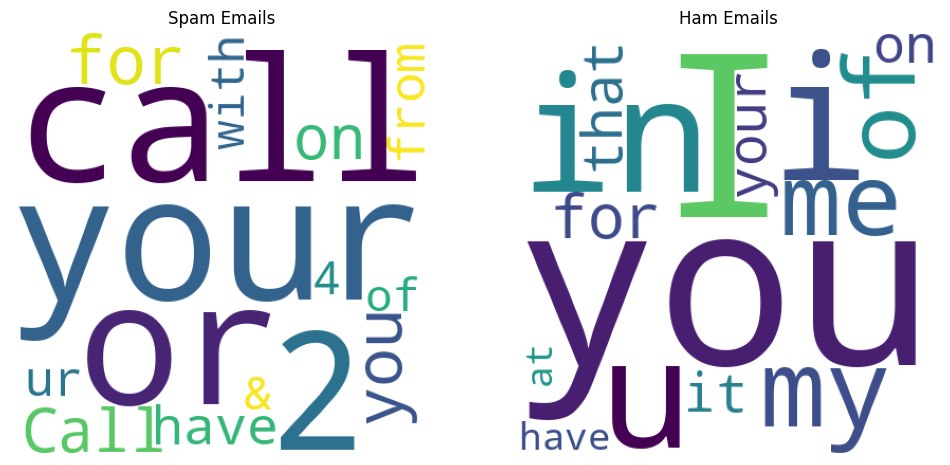

In [ ]:
spam_emails = data[data['Class'] == 'spam']
ham_emails = data[data['Class'] == 'ham']

spam_words = ' '.join(list(spam_emails['transformed_message'])).split()
spam_word_counts = Counter(spam_words)
spam_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(spam_word_counts.most_common((15))))

ham_words = ' '.join(list(ham_emails['transformed_message'])).split()
ham_word_counts = Counter(ham_words)
ham_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(ham_word_counts.most_common((15))))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud)
plt.title('Spam Emails')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud)
plt.title('Ham Emails')
plt.axis('off')

plt.show()

In [ ]:
data["Class"] = data["Class"].map({"ham": 0, "spam": 1})
X = data["transformed_message"].values
y = data["Class"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Implementation

We decided to use [Focal Loss](https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7), because it is designed to address class imbalance by focusing more on hard-to-classify examples. In traditional cross-entropy loss, all misclassifications are weighted equally, which can lead to poor performance on minority classes in imbalanced datasets. Focal Loss, however, down-weights easy-to-classify examples and up-weights harder ones by adding a scaling factor.



In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = K.cast(y_true, K.floatx())
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow(1. - p_t, gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

In [ ]:
tf.random.set_seed(42)
def create_vectorizer(X_train, split):
    vectorizer = layers.TextVectorization(
        split=split,
        standardize="lower"
    )
    vectorizer.adapt(X_train)
    return vectorizer

#### Choosing a metric

**Recall** measures how well the model catches all spam messages. A high recall means that nearly all spam emails are correctly marked as spam, so very few make it into the inbox.

However, focusing too much on recall can lead to more false positives, where important emails can end up in spam and lead to a bad user experience. (No one wants their graduation ceremony invitation email to end up in a spam.)

So in usual cases, it is a good practice to focus on the precision score when classifying scam. However, there is one point to take into consideration, and that is our imbalanced dataset. Since there is 86.6% of ham in our data, looking only at **precission** could be misleading, as the model would just learn that classifying a message as a ham is a win.

Therefore, we want to use both **precision** and **recall** as our metrics, as this minimizes the number of important emails marked as **spam** and takes into consideration our imbalanced dataset.


In the next part we discuss or choices when building models. The results will be discussed in **Models Evaluation**

### LSTM

First we decided to take the approach with long short-term memory model - this is a type of recurrent neural network used for capturing sequential patterns in data (in our case, perhaps something like sentence structure or character sequences), while using a complex structure of multiple gates (input, forget, output) .

 The Embedding layer converts characters into low-dimensional vectors, to learn the patterns. It will do so from left-to-right and right-to-left (hence the <b> Bidirectional </b> layers).

We use **leaky reLU** to prevent dead neurons during training. Finally, to prevent overfitting we drop 50% of its connections and use Adam optimizer with weight decay.

Once the model was build we fit the data and used few callbacks like **EarlyStopping** and **ReduceLROnPlateu**, so the model doesn't keep running once it stops improving to save time and compute units. We also standardized the characters into lower-case and decided to do the character split first - so each character is treated as its separate token.

In [ ]:
def build_model_LSTM(vocab_size, lstm_units_1=128, lstm_units_2=64,
                    dense_units=64, embedding_dim=32, learning_rate=0.001):
    model = models.Sequential([
        layers.Input(shape=(None,)),
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(lstm_units_1, return_sequences=True,
                                       kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Bidirectional(layers.LSTM(lstm_units_2,
                                       kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        layers.BatchNormalization(),
        layers.Dense(dense_units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=0.01
    )

    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=4, alpha=0.75),
        metrics=['precision', 'recall']
    )
    return model

In [ ]:
lstm_vectorizer = create_vectorizer(X_train, "character")
lstm_vocab_size = lstm_vectorizer.vocabulary_size()


X_train_vec = lstm_vectorizer(X_train)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)


lstm_model = build_model_LSTM(vocab_size=lstm_vocab_size)
lstm_history = lstm_model.fit(
    X_train_vec, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

Epoch 1/15
56/56 - 10s - 182ms/step - loss: 3.4962 - precision: 0.2791 - recall: 0.7734 - val_loss: 1.5036 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
56/56 - 3s - 60ms/step - loss: 0.7822 - precision: 0.5066 - recall: 0.8366 - val_loss: 0.3565 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
56/56 - 3s - 60ms/step - loss: 0.1832 - precision: 0.6728 - recall: 0.8736 - val_loss: 0.1257 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/15
56/56 - 3s - 60ms/step - loss: 0.0546 - precision: 0.7704 - recall: 0.8845 - val_loss: 0.0690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/15
56/56 - 3s - 59ms/step - loss: 0.0240 - precision: 0.7849 - recall: 0.8824 - val_loss: 0.0529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/15
56/56 - 3s - 60ms/step - loss: 0.0116 - precision: 0.8191 - recall: 0.8780 - 

### GRU

The GRU (or the Gated Reccurent Unit) is very similiar in fashion to LSTM. It's also a recurrent neural network, used for capturing sequences in data but just little less complex. It has less parameters and lacking an output gate. Because of this, it's also less computationaly expensive but aren't as reliable in capturing long-term dependencies in data.

Just as before, the TextVecitorization layer converts text into numbers and this time we are splitting by <b> whitespace </b> - which means each word is seen as separate token. This also reduces the complexity, when compared to the LSTM model. The model structure is a bit different, albeit it still uses the Bidirectional layers.
One important distinction is the presence of the **BatchNormalization** layer. This layer normalizes the outputs of the previous layer and makes training more stable.



In [ ]:
def build_model_GRU(vocab_size, gru_units_1=128, gru_units_2=64,
                   dense_units=64, learning_rate=0.0001):


    model = models.Sequential([
        layers.Input(shape=(None,)),
        layers.Embedding(input_dim=vocab_size, output_dim=64, mask_zero=True),

        layers.Bidirectional(layers.GRU(gru_units_1, return_sequences=True)),
        layers.Dropout(0.3),

        layers.BatchNormalization(),

        layers.Bidirectional(layers.GRU(gru_units_2)),
        layers.Dropout(0.3),

        layers.BatchNormalization(),

        layers.Dense(dense_units, activation='leaky_relu'),  # Using LeakyReLU, because it might have issue with dying neurons
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    ])

    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
                  loss=focal_loss(gamma=2, alpha=0.25),
                  metrics=['precision', 'recall'])

    return model

In [ ]:
gru_vectorizer = create_vectorizer(X_train, "whitespace")
gru_vocab_size = gru_vectorizer.vocabulary_size()


X_train_vec = gru_vectorizer(X_train)


early_stopping = EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1)

gru_model = build_model_GRU(vocab_size=gru_vocab_size)
gru_history = gru_model.fit(
    X_train_vec, y_train,
    epochs=15,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.3609 - precision: 0.1394 - recall: 0.6208 - val_loss: 0.0964 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1422 - precision: 0.2097 - recall: 0.5059 - val_loss: 0.0663 - val_precision: 0.8750 - val_recall: 0.0551 - learning_rate: 1.0000e-04
Epoch 3/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0870 - precision: 0.3320 - recall: 0.5302 - val_loss: 0.0440 - val_precision: 0.8837 - val_recall: 0.2992 - learning_rate: 1.0000e-04
Epoch 4/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0648 - precision: 0.4556 - recall: 0.4757 - val_loss: 0.0374 - val_precision: 0.9155 - val_recall: 0.5118 - learning_rate: 1.0000e-04
Epoch 5/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0520 - precision: 0.6553 - recall: 0.6243 - val_loss: 0.0340 - val_precision: 0.9405 - val_recall: 0.6220 - learning_rate: 1.0000e-04
Epoch 6

### Models Evaluation

We can see the GRU model preformed better than the LSTM variant. This could be for few reasons.

1. The **dataset isn't big enough** to handle the complexity of long short-term memory. The model is better suited for large and complex dataset where capturing long-term dependencies is critical. Its less complex but faster counter-part however is clearly just as good at finding spam (precision) while using less computational units.
As we can see on the graph below, the GRU accuracy shoots up high straight from the get go and even after experiencing slight loss, the model does not become unstable with its predictions. This can't be said about the LSTM model which also explodes at the beggining but becomes very unstable with validation data.

2. **The character vs whitespace split**. Or, more commonly known as letter vs word tokenization. In the LSTM case, the letter tokenization was supposed to adhere to the complexity demands, seeing that it learns over longer sequences but it can be open to incomprehensible gibberish and typos - which can occur in both spam and ham emails. This could also be the reason for the obvious fluctuation in the model's precision.
The GRU model with whitespace split however, was able to catch on meaning and semantics (word patterns such as "BUY THIS" and such). It's simpler and focuses on key details as oppossed to microscopic differences.

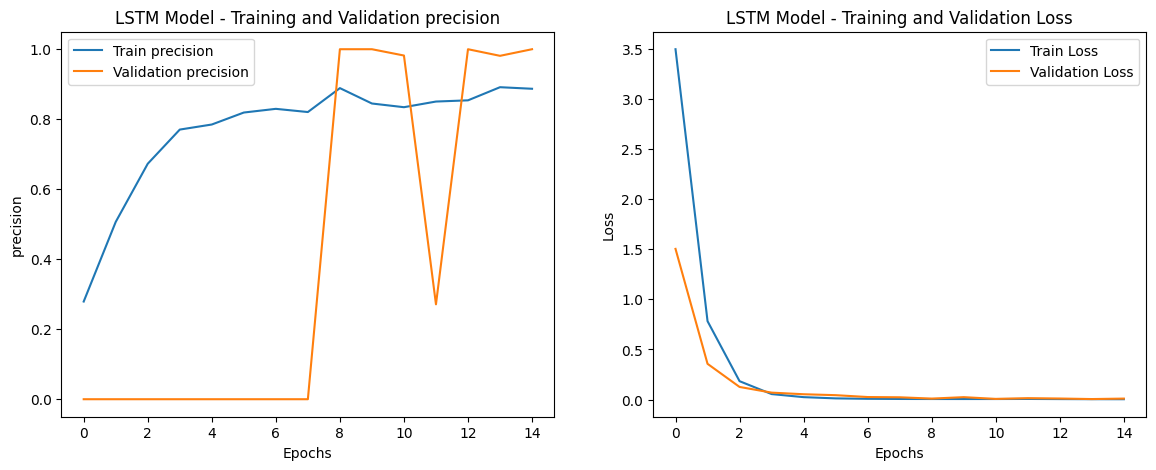

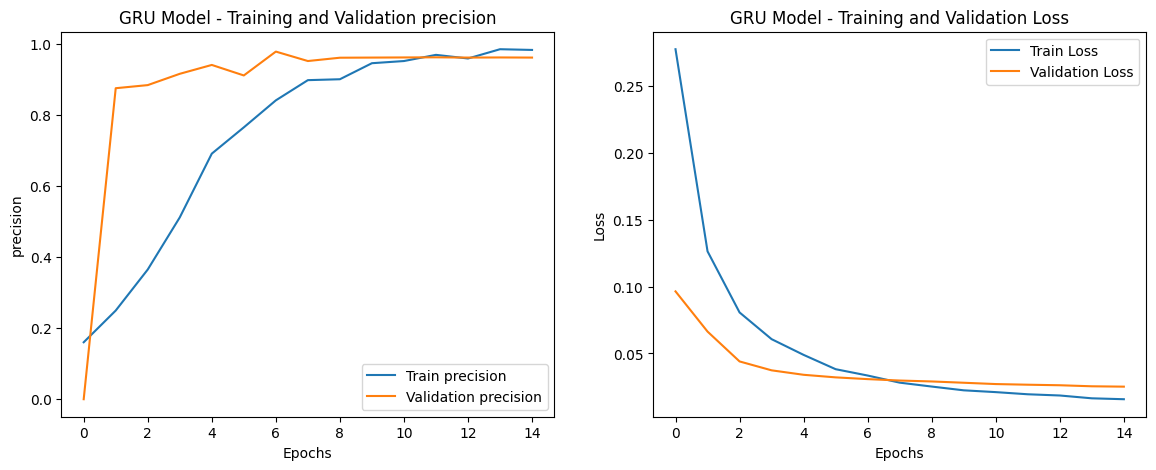

In [ ]:
# Plot Training History
def plot_history(history, model_name):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["precision"], label="Train precision")
    plt.plot(history.history["val_precision"], label="Validation precision")
    plt.xlabel("Epochs")
    plt.ylabel("precision")
    plt.legend()
    plt.title(f"{model_name} - Training and Validation precision")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{model_name} - Training and Validation Loss")

    plt.show()

plot_history(lstm_history, "LSTM Model")
plot_history(gru_history, "GRU Model")


Looking at the validation precision of `lstm`, there's significant instability with sudden jumps. The sudden jumps in validation precision could happen because the validation set is too small or imbalanced, causing extreme swings when the model changes its predictions on just a few examples. The initial gap in loss curves suggests the model is memorizing training data too quickly rather than learning generalizable patterns.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} - F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

LSTM Model - F1 Score: 0.9211


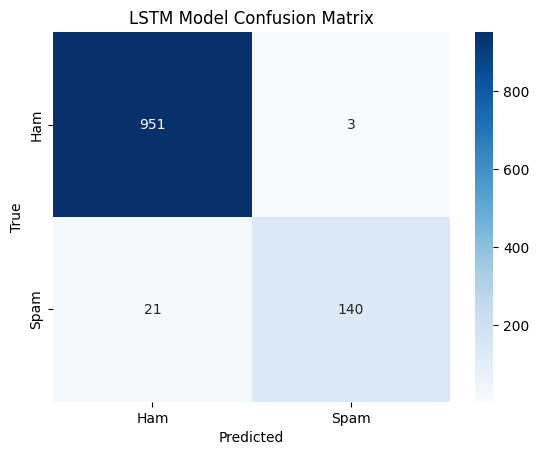

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

GRU Model - F1 Score: 0.8662


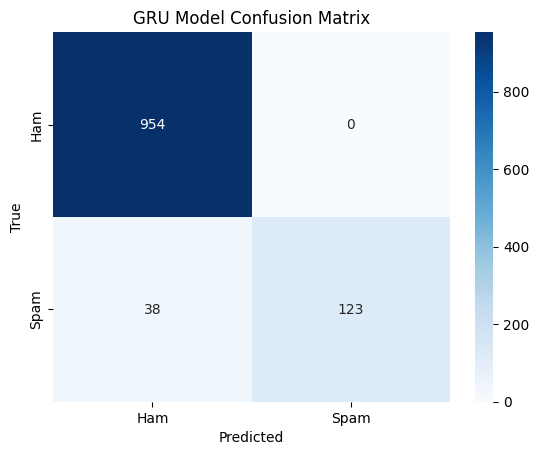

In [ ]:
X_test_vec = lstm_vectorizer(X_test)
evaluate_model(lstm_model, X_test_vec, y_test, "LSTM Model")

X_test_vec = gru_vectorizer(X_test)
evaluate_model(gru_model, X_test_vec, y_test, "GRU Model")

#The F1 score

From the confusion matrices above we can compare the F1 score of the models. Both models clearly perform well with identifying Ham - this is good because it means the model wouldn't separate important post as spam.

The GRU model outperforms the LTSM model in spam detection in this case, but when we ran the model multiple times, the results got a bit unstable. Sometimes, the LSTM model got better, but in most cases, it was GRU that had a better F1 score.

Images above are our interesting figures.

### Predicting custom messages

We gathered some custom messages and tested, how well can the model predict real life scenarios:

In [ ]:
def predict_messages(model, vectorizer, sentences):

    sentences = [sentence.lower() for sentence in sentences]
    vectorized_sentences = vectorizer(sentences)
    predictions = model.predict(vectorized_sentences)

    results = []
    for i, prediction in enumerate(predictions):
        label = 'spam' if prediction > 0.5 else 'ham'
        confidence = prediction[0] if label == 'spam' else 1 - prediction[0]
        results.append({
            "sentence": sentences[i],
            "prediction": label,
            "confidence": confidence
        })
    return results

In [ ]:
sentences = [
    #spam
    "Final notice: Your loan approval expires soon. Contact us now to proceed.",
    "Urgent! Your account has been compromised. Click here to secure it now!",
    "Limited time offer! Buy one get one free on all items. Visit our website now!",
    "You have an outstanding balance of $500. Click here to make a payment.",
    "Congratulations! You’re our lucky winner. Claim your prize now!",
    "You’ve been selected! Act now to claim your $1,000 reward. Click the link to verify your details!",
    "Exclusive offer just for you! Get a brand new iPhone for free! Limited stock, don’t miss out—click now!"


    #ham
    "Meeting rescheduled to 3 PM. Let me know if that works for you.",
    "Hey! Just wanted to check if you’re coming to the party tonight.",
    "Can we catch up for lunch tomorrow?",
    "Don't forget to pick up milk on your way home.",
    "Hope you’re doing well. Let’s connect sometime next week."
]

lstm_results = predict_messages(lstm_model, lstm_vectorizer, sentences)
gru_results = predict_messages(gru_model, gru_vectorizer, sentences)

lstm_results = predict_messages(lstm_model, lstm_vectorizer, sentences)
gru_results = predict_messages(gru_model, gru_vectorizer, sentences)

# Print results
for lstm_result, gru_result in zip(lstm_results, gru_results):
    sentence = lstm_result['sentence']
    print(f"Sentence: '{sentence}'")
    print(f"LSTM Prediction: {lstm_result['prediction']} (Confidence: {lstm_result['confidence']:.2f})")
    print(f"GRU Prediction: {gru_result['prediction']} (Confidence: {gru_result['confidence']:.2f})")
    print("\n" + "-"*50 + "\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Sentence: 'final notice: your loan approval expires soon. contact us now to proceed.'
LSTM Prediction: ham (Confidence: 0.54)
GRU Prediction: spam (Confidence: 0.64)

--------------------------------------------------

Sentence: 'urgent! your account has been compromised. click here to secure it now!'
LSTM Prediction: ham (Confidence: 0.54)
GRU Prediction: spam (Confidence: 0.79)

--------------------------------------------------

Sentence: 'limited time offer! buy one get one free on all items. visit our website now!'
LSTM Prediction: ham (Confidence: 0.57)
GRU Prediction: ham (Confidence: 0.72)

--------------------------------------------------

Sentence: 'you have an outstanding balance of $500. click here to make a payment.'
LSTM Prediction: ham (Confidence: 0.62)
GRU Prediction: ham (Confidence: 0.56)

-------------------------

As we can see above, the modeld predicted some of the messages as incorretly. Especially, `lstm` predicted all messages as `ham`. This is not exactly what we expected based on how the model performed before. One of the reasons why the model was confused could be that the sentences were shorter on average than in the dataset (Here the longest ham message is 103 characters, in the dataset an average was around 135 characters for a spam message).

An idea on how to improve the model could be adding the message length to the end of the message, so that the model has some more meaningful data to learn from. (Since the message length difference is quite big in this dataset).

### One more Interesting figure

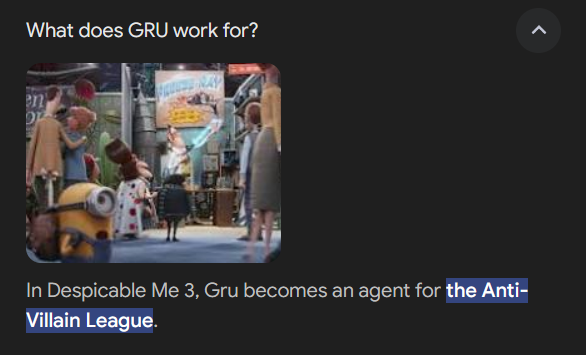